In [1]:
import scipy.io

# Datei laden
data = scipy.io.loadmat("data/cube/heatcube_0001.mat")

# Alle enthaltenen Variablennamen anzeigen

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'HSI'])


In [2]:
HSI = data['HSI']
print("Shape:", HSI.shape)
print("Dtype:", HSI.dtype)
print("Min:", HSI.min(), "Max:", HSI.max())

Shape: (260, 1500, 49)
Dtype: float64
Min: 0.02971271468914074 Max: 0.12882922348753414


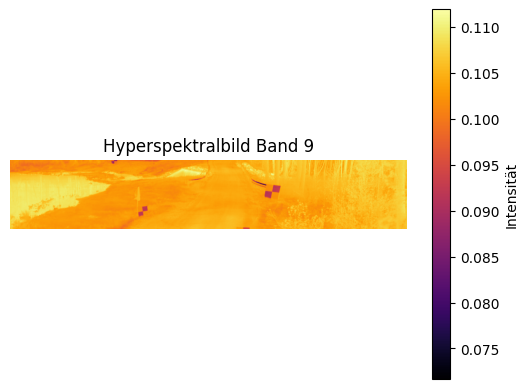

In [5]:
import matplotlib.pyplot as plt

band_index = 9
plt.imshow(HSI[:, :, band_index], cmap='inferno')
plt.title(f"Hyperspektralbild Band {band_index}")
plt.colorbar(label="Intensität")
plt.axis('off')
plt.show()

Epoch 0: Loss = 856658508819464192.000000
Epoch 200: Loss = 1205925348114432.000000
Epoch 400: Loss = 519015189446656.000000
Epoch 600: Loss = 420479277989888.000000
Epoch 800: Loss = 386802372313088.000000
Epoch 1000: Loss = 371238484574208.000000
Epoch 1200: Loss = 362784277659648.000000
Epoch 1400: Loss = 357695446056960.000000
Epoch 1600: Loss = 354405266227200.000000
Epoch 1800: Loss = 352162655764480.000000
Epoch 2000: Loss = 350570598629376.000000
Epoch 2200: Loss = 349403441266688.000000
Epoch 2400: Loss = 348525120454656.000000
Epoch 2600: Loss = 347849770401792.000000
Epoch 2800: Loss = 347321019662336.000000
Epoch 3000: Loss = 346900716847104.000000
Epoch 3200: Loss = 346562152628224.000000
Epoch 3400: Loss = 346286402306048.000000
Epoch 3600: Loss = 346059540791296.000000
Epoch 3800: Loss = 345871333982208.000000
Epoch 4000: Loss = 345714064359424.000000
Epoch 4200: Loss = 345581692125184.000000
Epoch 4400: Loss = 345469687431168.000000
Epoch 4600: Loss = 345374325735424.00

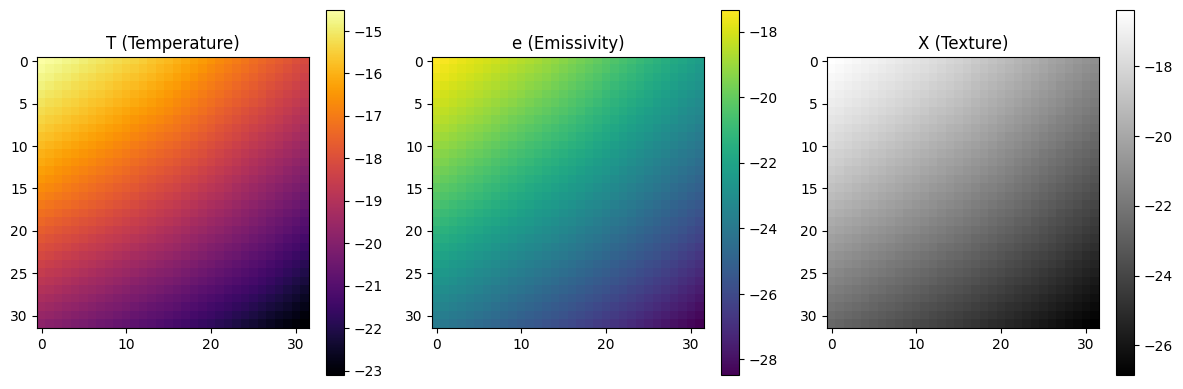

In [8]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# === 1. HADAR-Dateien laden ===
# ⛔️ Achte darauf, dass diese Pfade korrekt sind!
path_hsi = "/home/lukelo/Ubuntu Intelligence/Praxis Kedorion/Projekte/Intern/Yehior/research/PINN/data/cube/heatcube_0001.mat"
path_wn  = "/home/lukelo/Ubuntu Intelligence/Praxis Kedorion/Projekte/Intern/Yehior/research/PINN/data/wavenumber_ExperimentalScenes.mat"

# Lade die Hyperspektraldaten und Wellenzahlen
data = scipy.io.loadmat(path_hsi)
HSI = data['HSI']  # (260, 1500, 49)

wn_data = scipy.io.loadmat(path_wn)
wavenumbers = wn_data['wn'].squeeze().astype(np.float32)  # (49,)

# === 2. Daten vorbereiten ===
# Wir extrahieren einen kleinen Patch (32x32 Pixel) für das Training
H, W, C = HSI.shape
x0, y0 = 100, 500  # Startposition für Patch
patch = HSI[x0:x0+32, y0:y0+32, :]  # (32, 32, 49)

# Als Torch-Tensoren konvertieren
spectra = torch.tensor(patch.reshape(-1, C), dtype=torch.float32)  # (1024, 49)
wn_tensor = torch.tensor(wavenumbers, dtype=torch.float32)  # (49,)
wn_norm = (wn_tensor - wn_tensor.min()) / (wn_tensor.max() - wn_tensor.min())  # normiert

# === 3. PINN-Modell ===
class PINN_TeX(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 3)  # Output: T, e, X
        )
    def forward(self, xy):
        return self.net(xy)

model = PINN_TeX()

# === 4. Planck-Funktion ===
def planck(wn_norm, T):
    c1 = 1.191e8
    c2 = 1.439
    wn = wn_norm.unsqueeze(0)  # (1, 49)
    T = T.unsqueeze(1)         # (N, 1)
    exponent = c2 * wn / T
    exponent = torch.clamp(exponent, max=80)  # Stabilisieren
    B = c1 * wn**3 / (torch.exp(exponent) - 1 + 1e-6)
    return B  # (N, 49)

# === 5. Eingaben vorbereiten (xy-Koordinaten) ===
grid_y, grid_x = torch.meshgrid(torch.linspace(0,1,32), torch.linspace(0,1,32), indexing="ij")
xy = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)  # (1024, 2)

# === 6. Training ===
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20000
loss_log = []

for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(xy)  # (1024, 3)
    
    # Stabile physikalische Werte
    T_pred = torch.nn.functional.softplus(pred[:, 0]) + 50       # [K]
    e_pred = torch.sigmoid(pred[:, 1]) * 0.98 + 0.01              # [0.01, 0.99]
    X_pred = torch.nn.functional.softplus(pred[:, 2]) + 1e-2      # >0
    
    # Planck + Mischung
    B = planck(wn_norm, T_pred)  # (1024, 49)
    S_hat = e_pred.unsqueeze(1) * B + (1 - e_pred.unsqueeze(1)) * X_pred.unsqueeze(1)

    loss = torch.mean((S_hat - spectra)**2)
    loss.backward()
    optimizer.step()

    loss_log.append(loss.item())
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# === 7. Ergebnisse anzeigen ===
with torch.no_grad():
    result = model(xy).detach().numpy()
    T_map = result[:, 0].reshape(32, 32)
    e_map = result[:, 1].reshape(32, 32)
    X_map = result[:, 2].reshape(32, 32)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("T (Temperature)")
plt.imshow(T_map, cmap='inferno')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("e (Emissivity)")
plt.imshow(e_map, cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("X (Texture)")
plt.imshow(X_map, cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.show()


In [10]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# === 1. Daten laden ===

hsi_path = "/home/lukelo/Ubuntu Intelligence/Praxis Kedorion/Projekte/Intern/Yehior/research/PINN/data/cube/heatcube_0001.mat"
wn_path  = "/home/lukelo/Ubuntu Intelligence/Praxis Kedorion/Projekte/Intern/Yehior/research/PINN/data/wavenumber_ExperimentalScenes.mat"

hsi = scipy.io.loadmat(hsi_path)['HSI']
wn = scipy.io.loadmat(wn_path)['wn'].squeeze()
wn = torch.tensor(wn, dtype=torch.float32)  # (49,)

# === 2. Patch vorbereiten (32x32 Pixel) ===
x0, y0 = 100, 500
patch = hsi[x0:x0+32, y0:y0+32, :]  # (32, 32, 49)
patch = torch.tensor(patch, dtype=torch.float32)
H, W, C = patch.shape
spectra = patch.reshape(-1, C)  # (1024, 49)

# === 3. Input-Koordinaten (x,y) vorbereiten ===
grid_y, grid_x = torch.meshgrid(torch.linspace(0,1,H), torch.linspace(0,1,W), indexing="ij")
xy = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)  # (1024, 2)

# === 4. Modell definieren ===
class PINN_TeX(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 3)  # T, e, X
        )
    def forward(self, x):
        return self.model(x)

model = PINN_TeX()

# === 5. Planck-Funktion ===
def planck(wn, T):
    c1, c2 = 1.191e8, 1.439  # µW/cm²·sr·cm⁻⁴, K·cm
    wn = wn.view(1, -1)
    T = T.view(-1, 1)
    return c1 * wn**3 / (torch.exp(c2 * wn / (T + 1e-5)) - 1 + 1e-5)

# === 6. Physik-basiertes Residuum ===
def physics_residual(T, e, X, wn, S):
    B = planck(wn, T)
    S_hat = e.unsqueeze(1) * B + (1 - e.unsqueeze(1)) * X.unsqueeze(1)
    lhs = torch.gradient(S_hat / (1 - e.unsqueeze(1) + 1e-5), spacing=(wn,))[0]
    rhs = torch.gradient(e / (1 - e + 1e-5), spacing=(wn.mean(),))[0].unsqueeze(1) * B
    return lhs - rhs

# === 7. Training vorbereiten ===
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 3000
loss_log = []

for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(xy)
    T = pred[:, 0].clip(100, 500)
    e = pred[:, 1].clip(0.01, 0.99)
    X = pred[:, 2].clip(0.01, 1.0)

    # === 7.1 Datengestützter Loss (Rekonstruktion) ===
    B = planck(wn, T)
    S_pred = e.unsqueeze(1) * B + (1 - e.unsqueeze(1)) * X.unsqueeze(1)
    data_loss = torch.mean((S_pred - spectra)**2)

    # === 7.2 Physics Loss via PDE-Residuum ===
    res = physics_residual(T, e, X, wn, S_pred)
    physics_loss = torch.mean(res**2)

    # === 7.3 Total Loss ===
    loss = data_loss + 0.1 * physics_loss
    loss.backward()
    optimizer.step()

    if epoch % 300 == 0:
        print(f"Epoch {epoch}: Total={loss.item():.6f} | Data={data_loss.item():.6f} | PDE={physics_loss.item():.6f}")
    loss_log.append(loss.item())

# === 8. Ergebnisse plotten ===
with torch.no_grad():
    result = model(xy).detach().numpy()
    T_map = result[:, 0].reshape(H, W)
    e_map = result[:, 1].reshape(H, W)
    X_map = result[:, 2].reshape(H, W)
    res_map = physics_residual(
        torch.tensor(T_map).flatten(),
        torch.tensor(e_map).flatten(),
        torch.tensor(X_map).flatten(),
        wn,
        spectra
    ).detach().numpy().reshape(H, W, -1).mean(axis=2)

plt.figure(figsize=(14, 5))
plt.subplot(1, 4, 1); plt.imshow(T_map, cmap='inferno'); plt.title("T"); plt.colorbar()
plt.subplot(1, 4, 2); plt.imshow(e_map, cmap='viridis'); plt.title("e"); plt.colorbar()
plt.subplot(1, 4, 3); plt.imshow(X_map, cmap='gray'); plt.title("X"); plt.colorbar()
plt.subplot(1, 4, 4); plt.imshow(res_map, cmap='coolwarm'); plt.title("PDE Residuum"); plt.colorbar()
plt.tight_layout(); plt.show()


RuntimeError: torch.gradient expected spacing to be unspecified, a scalar, or a list of length equal to 'self.dim() = 2', since dim argument was not given, but got a list of length 1